## Classification - Part 2: Imbalanced Data (BenchMark Model : Tree Based)
- Objective : 
    1. Classify yes class  along with their probability.

## 1.0 Constrains

### 1.1 Modeling Constraints : 
- Modeling Type : Classification    
- Model Explainaibility : 
    - 1. One Logistic Regression Model : Explainable Model
    - 2. Another Black Box Model : 
        
    
### 1.2 Data Constraint :
- Primary Data : 
    - Dependent / Outcome Variable :  y (0/1)
    - Independent / Predictor Variables :  100 Feature Variables (Categorical, numerical)
- Imbalanced Data :  


### 1.3 Evaluation Metrics Constraint:
- Imbalanced Data specific Evaluation Metrics
- General constraints i.e accuracy leads to improper evaluation / modeling & final choice.

### 1.4 Framework Constraint : 
- This constraint is self-selected based on ease of use and data size.
- Scikit-learn. 
    - Scikit-Learn : Given that the Data-size is comparatively small, scikit-learn  is selected as the framework, given its comparative ease  or use and faster Iteration possiblity.
- TensorFlow/ Keras : Complex Deep Neural Network  modeling and GPU support is provided by TensorFlow / Keras, and hence is used for more complex NN modeling.
- StatsModel :
    - Scikit-learn provides more varied models(Forest, Boosting, Bagging, SVM, NNs), powerful parameter customisation and control. However the LR model generated by them have few model and model parameter statistics compared to StatsModel (i.e p-value, 95% CI, marginal_effects ). Hence we will use StatsModel's LogisticRegression in the second part.



## 1. Data Load: Modeling Ready Data
- Data has been preprocessed with the earlier notebook.
- We are loading the preprocessed data in this step.

In [4]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


X_train = pd.read_csv("Data/ModelReadyData/X_train.csv")
y_train = pd.read_csv("Data/ModelReadyData/y_train.csv")
ckpt_train_df_pre_scaling = pd.read_csv("Data/ModelReadyData/ckpt_train_df_pre_scaling.csv")

# X_valid = pd.read_csv("Data/ModelReadyData/X_valid.csv")
# y_valid = pd.read_csv("Data/ModelReadyData/y_valid.csv")
# test_df = pd.read_csv("Data/ModelReadyData/test_df.csv")

# X_train_smote = pd.read_csv("Data/ModelReadyData/X_train_smote.csv")
# y_train_smote = pd.read_csv("Data/ModelReadyData/y_train_smote.csv")



## Dataset Creation Functions

In [5]:
## DataSet Creation
def get_stratified_data(X_df, y_series, test_size=0.2, verbose=False, seed=4):
    from sklearn.model_selection import StratifiedShuffleSplit

    feature_cols = list(X_df.columns)
    # target_col = y_df.columns

    X = np.array(X_df)
    y = np.array(y_series)

    sss = StratifiedShuffleSplit(n_splits=2, test_size=test_size, random_state=seed)
    sss.get_n_splits(X, y)

    for train_index, test_index in sss.split(X, y):
        if verbose:
            print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

    X_train = pd.DataFrame(X_train, columns=feature_cols)
    X_test = pd.DataFrame(X_test, columns=feature_cols)

    y_train = pd.DataFrame(y_train)
    y_test = pd.DataFrame(y_test)

    if verbose:
        print(f"\n ...No. of Training Data : {len(X_train)}")
        print(f" ...No. of Test Data     : {len(X_test)}")
        print(f" ...No. of Features : {len(X_train.columns)}")
        print(f" ...Train Bincount : {np.bincount(y_train[0])}")
        print(f" ...Test Bincount  : {np.bincount(y_test[0])}")

    return X_train, y_train, X_test, y_test

### 4.2 Evaluation Metric Selection:

- Accuracy is a bad Evaluation metric given  highly imbalanced nature of Data.
- We will choose AUC, recall, F1-score and additionally use confusion matrix. 
- Recall : Ability of model to find all positive classes
- Precision : Ability of model to not label as positive a sample that is negative.
- Balanced accuracy : avg of recall across all classes.


In [14]:
from sklearn.model_selection import cross_validate

scoring = ["roc_auc", "recall", "precision", "accuracy", "balanced_accuracy", "f1"]

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from typing import List
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn import tree
from sklearn.model_selection import cross_validate


# Defining the confusion matrix function
def plot_confusion_matrix(cm, class_labels, title="Confusion matrix", cmap=plt.cm.Blues):
    import itertools

    plt.figure(figsize=(3, 3))
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_labels))
    plt.xticks(tick_marks, class_labels, rotation=45)
    plt.yticks(tick_marks, class_labels)

    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()


def area_under_roc(y, pred):
    from sklearn import metrics

    # fpr,tpr, thresholds = metrics.roc_curve(y, pred, pos_label=2 )
    auc = metrics.roc_auc_score(y, pred)
    # print('fpr,tpr, AUC (higher is better)', fpr, tpr, auc)
    print("AUC (higher is better)", auc)
    return auc


def eval_classification(
    y_test,
    ypred_test,
    class_labels=["Retained", "Churn - Lost"],
    title="Confusion Matrix",
    metrics=["confusion_matrix"],
):
    returned_metrics = []

    if "auc" in metrics:
        auc = area_under_roc(y_test, ypred_test)
        returned_metrics.append(auc)
    if "confusion_matrix" in metrics:
        print("Confusion report is")
        print(classification_report(y_test, ypred_test))
        conf_matrix = confusion_matrix(y_test, ypred_test)
        plot_confusion_matrix(conf_matrix, class_labels=class_labels, title=title)
        returned_metrics.append(conf_matrix)

    return returned_metrics[0] if len(returned_metrics) == 1 else returned_metrics


def plot_roc(y_test: List[int], y_test_proba: List[float]):
    auc = roc_auc_score(y_test, y_test_proba)
    print("Logistic: ROC AUC=%.3f" % (auc))

    # # keep probabilities for the positive outcome only
    # probability_positive_class = y_test_proba[:, 1]
    probability_positive_class = y_test_proba

    fpr, tpr, _ = roc_curve(y_test, probability_positive_class)

    pyplot.plot(fpr, tpr, marker=".", label="")
    pyplot.title("ROC Curve")
    pyplot.xlabel("False Positive Rate (False Alarm Rate)")
    pyplot.ylabel("True Positive Rate ( Sensitivity, Hit Rate)")
    pyplot.legend()
    pyplot.show()


def plot_roc_for_binary_prediction_label(y_test, y_test_prediction):
    from plot_metric.functions import BinaryClassification

    bc = BinaryClassification(y_test, y_test_prediction, labels=["Class 1", "Class 2"])
    # Figures
    plt.figure(figsize=(5, 5))
    bc.plot_roc_curve()
    plt.show()


def create_new_score_tracker_df(scoring):
    score_tracker_dict = {"model_name": []}
    scores = {}
    for cur_scoring in scoring:
        score_tracker_dict.update({cur_scoring: []})

    score_tracker_df = pd.DataFrame(score_tracker_dict)
    return score_tracker_df


def add_cv_score_to_df(df, model_descriptor_name, scoring, cur_clf_cv_result):
    cur_scores = {"model_name": model_descriptor_name}
    for cur_scoring in scoring:
        cur_scores.update({cur_scoring: round(cur_clf_cv_result["test_" + cur_scoring].mean(), 2)})

    df = df.append(cur_scores, ignore_index=True)
    df = df.drop_duplicates(keep="last")
    return df


def get_cv_scores(clf, model_descriptor_name, X, y, scoring, score_tracker_df=None, cv_fold=5):
    # Create Score tracker df if first run
    if score_tracker_df is None:
        print("Created New Score Tracker")
        score_tracker_df = create_new_score_tracker_df(scoring)

    cur_clf_cv_result = cross_validate(clf, X, y, cv=cv_fold, scoring=scoring)
    score_tracker_df = add_cv_score_to_df(score_tracker_df, model_descriptor_name, scoring, cur_clf_cv_result)

    return score_tracker_df


def get_benchmark_cv_scores(clf, x_columns, df, model_name, score_tracker_df=None):
    if x_columns is None:
        x_columns = list(df.columns)
        x_columns.remove("y")
    print(f" Columns : {len(x_columns)}")
    cur_X_train, cur_y_train, _, _ = get_stratified_data(df[x_columns], df["y"], test_size=0.01, seed=4)
    score_tracker_df = get_cv_scores(
        clf=clf,
        X=cur_X_train,
        y=cur_y_train,
        cv_fold=5,
        scoring=scoring,
        model_descriptor_name=model_name,
        score_tracker_df=score_tracker_df,
    )
    return score_tracker_df


def get_clasifier_evaluation(clf, X_train=X_train, y_train=y_train, X_valid=None, y_valid=None):
    clf.fit(X_train, y_train)
    y_pred_valid = clf.predict(X_valid)
    eval_classification(y_valid, y_pred_valid, class_labels=["no", "yes"], metrics=["auc", "confusion_matrix"])


def simple_tree(
    X_trainR,
    y_trainR,
    X_testR,
    y_testR,
    max_depth=None,
    class_weight=None,
    class_labels=["yes", "no"],
    metrics=["confusion_matrix"],
):
    from sklearn import tree

    clf = tree.DecisionTreeClassifier(max_depth=max_depth, class_weight=class_weight)
    clf.fit(X_trainR, y_trainR)
    ypred_testR = clf.predict(X_testR)

    eval_classification(y_testR, ypred_testR, class_labels=class_labels, metrics=metrics)
    return clf


### 4.3 Benchmark Model: Tree Based

#### 4.3.1 Simple Tree


TRAIN: [  309 29661 12802 ... 39161 36620  6392] TEST: [25266 37182  8592 ... 14682 15691 39481]
TRAIN: [24571 16075  2874 ... 33494 11280 34824] TEST: [ 2283  9365 11857 ... 28712 39145 16578]

 ...No. of Training Data : 32000
 ...No. of Test Data     : 8000
 ...No. of Features : 171
 ...Train Bincount : [27358  4642]
 ...Test Bincount  : [6839 1161]
AUC (higher is better) 0.5706240454282634
Confusion report is
              precision    recall  f1-score   support

           0       0.88      0.87      0.87      6839
           1       0.26      0.28      0.27      1161

    accuracy                           0.78      8000
   macro avg       0.57      0.57      0.57      8000
weighted avg       0.79      0.78      0.78      8000



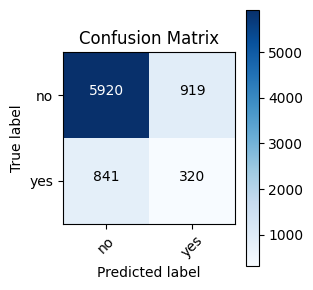

In [15]:
train_df_no_preproces = ckpt_train_df_pre_scaling.copy()
feature_columns = list(train_df_no_preproces.columns)
feature_columns.remove("y")
feature_columns
X_all_no_preprocess = train_df_no_preproces[feature_columns]
y_all_no_preprocess = train_df_no_preproces["y"]

X_train_no_preprocess, y_train_no_preprocess, X_valid_no_preprocess, y_valid_no_preprocess = get_stratified_data(
    X_all_no_preprocess, y_all_no_preprocess, test_size=0.2, verbose=True
)


simple_tree_clf = simple_tree(
    X_train_no_preprocess,
    y_train_no_preprocess,
    X_valid_no_preprocess,
    y_valid_no_preprocess,
    class_weight=None,
    class_labels=["no", "yes"],
    metrics=["auc", "confusion_matrix"],
)


In [16]:
scoring = ["roc_auc", "recall", "precision", "accuracy", "balanced_accuracy", "f1" ]
score_tracker_df = get_cv_scores(
    clf=tree.DecisionTreeClassifier(max_depth=None, class_weight=None),
    X=X_train,
    y=y_train,
    cv_fold=5,
    scoring=scoring,
    model_descriptor_name="Simple Tree Unbalanced",
    score_tracker_df=None,
)
score_tracker_df = get_cv_scores(
    clf=tree.DecisionTreeClassifier(max_depth=None, class_weight="balanced"),
    X=X_train,
    y=y_train,
    cv_fold=5,
    scoring=scoring,
    model_descriptor_name="Simple Tree balanced",
    score_tracker_df=score_tracker_df,
)
score_tracker_df

Created New Score Tracker


/tmp/ipykernel_480307/3839576792.py:115: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(cur_scores, ignore_index=True)
/tmp/ipykernel_480307/3839576792.py:115: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(cur_scores, ignore_index=True)


,model_name,roc_auc,recall,precision,accuracy,balanced_accuracy,f1
0,Simple Tree Unbalanced,0.57,0.27,0.25,0.77,0.57,0.26
1,Simple Tree balanced,0.57,0.27,0.25,0.78,0.57,0.26


In [17]:
score_tracker_df.to_csv("Data/Output/score_tracker_benchmark_decision_tree.csv")